In [1]:
import pandas as pd
import numpy as np  
from numpy import random

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from torchnlp.encoders import LabelEncoder

from transformers import AutoModel, AutoTokenizer

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8


the data here has been processed from raw icd9 diagnosis codes data in mimic-iii.

Whilst each subject can ultimately have multiple concurrent icd9 diagnoses - we are framing the task as predicting the diagnos code per admissions/discharge event, thus treating as i.i.d. Similar to that of : https://github.com/simonlevine/clinical-longformer/blob/master/Written%20Submission.pdf 


In [2]:
data_dir = "../../data/intermediary-data/"

train_df = pd.read_csv(f"{data_dir}/notes2diagnosis-icd-train.csv", index_col = None)
top_50_df = pd.read_csv(f"{data_dir}/top_50_icd9/train.csv", index_col = None)

In [8]:
train_df.shape

(28105, 4)

In [4]:
top_50_df.head()

,Unnamed: 0,text,label
0,1,: : : Sex: F Service: CARDIOTHORACIC Allergies...,4240
1,3,: : : Sex: F Service: NEONATOLOGY HISTORY: wee...,V3001
2,6,: : : Sex: M Service: CARDIOTHORACIC Allergies...,41041
3,7,: : : Sex: F Service: MEDICINE Allergies: Peni...,51881
4,8,: : : Sex: F Service: CARDIOTHORACIC Allergies...,3962


In [9]:
train_df.head()

,HADM_ID,TEXT,CATEGORY,ICD9_CODE
0,188354.0,: : : Sex: F Service: MEDICINE Allergies: Sulf...,Discharge summary,44023
1,104471.0,: : : Sex: F Service: CARDIOTHORACIC Allergies...,Discharge summary,4240
2,157504.0,: : : Sex: M Service: NBB HISTORY OF PRESENT I...,Discharge summary,7746
3,157762.0,: : : Sex: F Service: NEONATOLOGY HISTORY: wee...,Discharge summary,V3001
4,118769.0,: : : Sex: M Service: CARDIOTHORACIC Allergies...,Discharge summary,3963


In [10]:
# number of unique ids:

len(train_df.HADM_ID.unique())

28105

In [6]:
# number of uniqu icd9 codes
len(train_df.ICD9_CODE.unique())

2107

In [3]:
# just get top 50 for now

top_50_icd9 = train_df['ICD9_CODE'].value_counts()[:50].index.tolist()
top_50_icd9

['41401',
 '0389',
 '41071',
 'V3001',
 '4241',
 '51881',
 'V3000',
 'V3101',
 '431',
 '4240',
 '486',
 '5070',
 '430',
 '4280',
 '41011',
 '41041',
 '5789',
 '5849',
 '1983',
 '5770',
 '99662',
 '99859',
 '43411',
 '42731',
 '03842',
 '56212',
 '43491',
 '4373',
 'V3401',
 '51884',
 '5712',
 '4271',
 '85221',
 '42823',
 '03811',
 '03849',
 '41519',
 '4321',
 '4414',
 '0380',
 '53240',
 '99811',
 '1623',
 '3962',
 '5715',
 '43310',
 '042',
 '44101',
 '5761',
 '29181']

In [24]:
top_50_icd9 = train_df['ICD9_CODE'].value_counts()[:50].sort_index().index.tolist()

In [35]:
top_50_icd9

['0380',
 '03811',
 '03842',
 '03849',
 '0389',
 '042',
 '1623',
 '1983',
 '29181',
 '3962',
 '41011',
 '41041',
 '41071',
 '41401',
 '41519',
 '4240',
 '4241',
 '4271',
 '42731',
 '4280',
 '42823',
 '430',
 '431',
 '4321',
 '43310',
 '43411',
 '43491',
 '4373',
 '44101',
 '4414',
 '486',
 '5070',
 '51881',
 '51884',
 '53240',
 '56212',
 '5712',
 '5715',
 '5761',
 '5770',
 '5789',
 '5849',
 '85221',
 '99662',
 '99811',
 '99859',
 'V3000',
 'V3001',
 'V3101',
 'V3401']

In [34]:
top_50_already = top_50_df['label'].value_counts()[:50].sort_index().index.tolist()
top_50_already

['0380',
 '03811',
 '03842',
 '03849',
 '0389',
 '042',
 '1623',
 '1983',
 '29181',
 '3962',
 '41011',
 '41041',
 '41071',
 '41401',
 '41519',
 '4240',
 '4241',
 '4271',
 '42731',
 '4280',
 '42823',
 '430',
 '431',
 '4321',
 '43310',
 '43411',
 '43491',
 '4373',
 '44101',
 '4414',
 '486',
 '5070',
 '51881',
 '51884',
 '53240',
 '56212',
 '5712',
 '5715',
 '5761',
 '5770',
 '5789',
 '5849',
 '85221',
 '99662',
 '99811',
 '99859',
 'V3000',
 'V3001',
 'V3101',
 'V3401']

<AxesSubplot:>

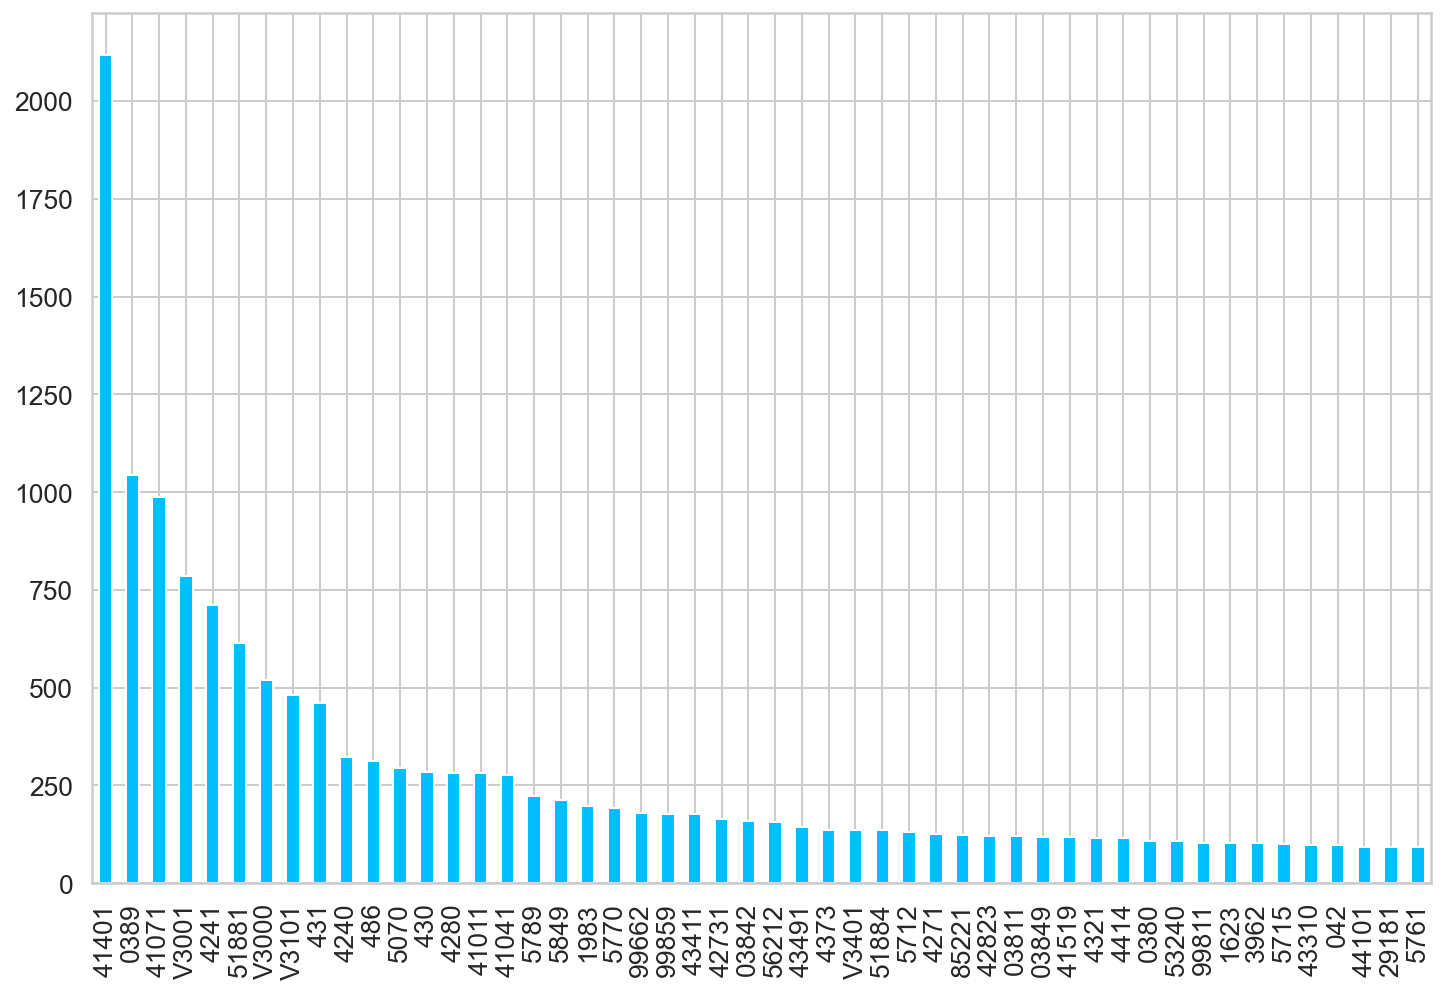

In [13]:
# do a lil plot
top_50_df = train_df[train_df['ICD9_CODE'].isin(top_50_icd9)]
top_50_df['ICD9_CODE'].value_counts().plot(kind = 'bar')

In [32]:
top_50_list = top_50_df['ICD9_CODE'].value_counts()
for code in top_50_list.keys():
    print(code)
    print(top_50_list[code])
    
    break

41401
2118


In [31]:
top_50_list.keys()

Index(['41401', '0389', '41071', 'V3001', '4241', '51881', 'V3000', 'V3101',
       '431', '4240', '486', '5070', '430', '4280', '41011', '41041', '5789',
       '5849', '1983', '5770', '99662', '99859', '43411', '42731', '03842',
       '56212', '43491', '4373', 'V3401', '51884', '5712', '4271', '85221',
       '42823', '03811', '03849', '41519', '4321', '4414', '0380', '53240',
       '99811', '1623', '3962', '5715', '43310', '042', '44101', '29181',
       '5761'],
      dtype='object')

In [5]:
# icd9 code lookup
from icd9cms.icd9 import search

In [38]:
# !pip install icd9cms

In [47]:
from tqdm import tqdm
def get_topN_icd9_descriptions(data_path, icd9_col = "ICD9_CODE",n=50, save_path = "../data/intermediary-data/top_50_icd9/"):
    '''
    Function to ingest the mimic dataset with icd9 diagnosis codes, select the top N occurences, obtain the natural language descriptions, and combine into a dataframe

    returns: dataframe containing icd9_code, counts, and descriptions - unique per row
    '''
    train_df = pd.read_csv(f"{data_path}", index_col = None)
    top_n_icd9 = train_df[icd9_col].value_counts()[:n].index.tolist()    
    df = train_df[train_df[icd9_col].isin(top_50_icd9)]
    icd9_value_counts = df[icd9_col].value_counts()
    df['ICD9_CODE'].value_counts().plot(kind = 'bar')

    combined_dicts = []
    for code in tqdm(icd9_value_counts.keys()):       


        # get icd9 description
        icd9_description = (",").join(str(search(code)).split(":")[1:3])

        
        combined_dicts.append({"icd9_code":code,"count":icd9_value_counts[code], "description":icd9_description})
        
    # combine into a dataframe 
    final_df = pd.DataFrame(combined_dicts)

    # save to file
    if save_path is not None:
        final_df.to_csv(f"{save_path}", index_col = None)
    return final_df

  0%|          | 0/50 [00:00<?, ?it/s]

41401
2118


,icd9_code,count,description
0,41401,2118,"Crnry athrscl natve vssl,Coronary atherosclero..."


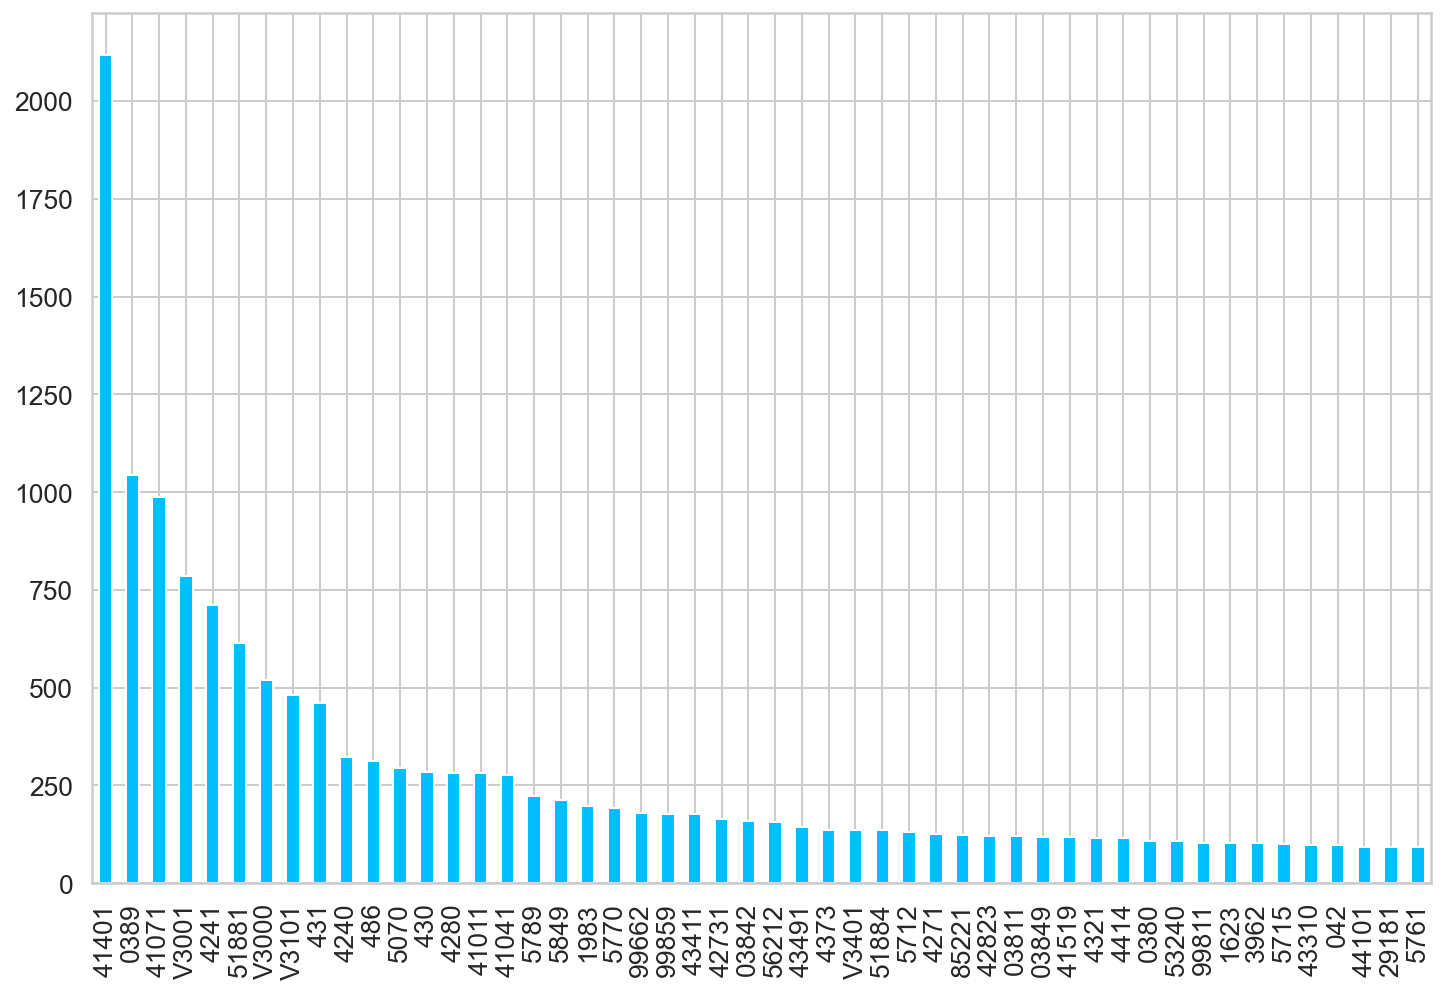

In [48]:
get_topN_icd9_descriptions(data_path=f"{data_dir}/notes2diagnosis-icd-train.csv")

In [26]:
 [str(search(code)) for code in top_50_icd9][42].split(":")

['1623',
 'Mal neo upper lobe lung',
 'Malignant neoplasm of upper lobe, bronchus or lung']

In [44]:
(",").join(str(search('41401')).split(":")[1:3])

'Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary artery'

In [33]:
get_icd9_descriptions(top_50_icd9)

NameError: name 'get_icd9_descriptions' is not defined

# can check the raw icd9 data files below

In [18]:
# raw icd 9 data
raw_data_dir = "/home/niallt/NLP_DPhil/DPhil_projects/mimic-icd9-classification/clinical-longformer/data/physionet.org/files/mimiciii/1.4/zipped_data/"
raw_icd9 = pd.read_csv(f"{raw_data_dir}/DIAGNOSES_ICD.csv.gz")

In [19]:
raw_icd9

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254
...,...,...,...,...,...
651042,639798,97503,188195,2.0,20280
651043,639799,97503,188195,3.0,V5869
651044,639800,97503,188195,4.0,V1279
651045,639801,97503,188195,5.0,5275


## look at label encder

In [7]:
# checking labels loaded from raw training and top50 subset produce same label encoder

In [25]:
labels = LabelEncoder(top_50_icd9, 
                    reserved_labels=[])

In [26]:
labels.index_to_token[13]

'41401'

In [27]:
labels.token_to_index['41401']

13

In [31]:
labels.vocab

['0380',
 '03811',
 '03842',
 '03849',
 '0389',
 '042',
 '1623',
 '1983',
 '29181',
 '3962',
 '41011',
 '41041',
 '41071',
 '41401',
 '41519',
 '4240',
 '4241',
 '4271',
 '42731',
 '4280',
 '42823',
 '430',
 '431',
 '4321',
 '43310',
 '43411',
 '43491',
 '4373',
 '44101',
 '4414',
 '486',
 '5070',
 '51881',
 '51884',
 '53240',
 '56212',
 '5712',
 '5715',
 '5761',
 '5770',
 '5789',
 '5849',
 '85221',
 '99662',
 '99811',
 '99859',
 'V3000',
 'V3001',
 'V3101',
 'V3401']

In [36]:
labels_2 = LabelEncoder(top_50_already, 
                    reserved_labels=[])

In [37]:
labels_2.index_to_token[13]

'41401'

In [38]:
labels_2.token_to_index['41401']

13

In [40]:
labels_2.vocab == labels.vocab

True

# Random spacy bits

In [30]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
 
sentence_1="spacy is cool but a bit of a pain spacy spacy"
# sentence_2="This is not good at all. We do not have any cheese here. Crocodiles are big"
 
 
 


In [38]:

sentence_1_random = sentence_1.split(" ")
sentence_1_random

['spacy', 'is', 'cool', 'but', 'a', 'bit', 'of', 'a', 'pain', 'spacy', 'spacy']

In [35]:
random.shuffle(sentence_1_random)

In [36]:
new_sentence = " ".join(sentence_1_random)

In [39]:
sentence_1="spacy is cool but a bit of a pain spacy spacy"
sentence_1_random = sentence_1.split(" ")
random.shuffle(sentence_1_random)
new_sentence = " ".join(sentence_1_random)

CountVec = CountVectorizer(ngram_range=(1,1), # to use bigrams ngram_range=(2,2)
                           )
#transform
Count_data = CountVec.fit_transform([sentence_1, new_sentence])
 
#create dataframe
cv_dataframe=pd.DataFrame(Count_data.toarray(),columns=CountVec.get_feature_names())
print(cv_dataframe)

   bit  but  cool  is  of  pain  spacy
0    1    1     1   1   1     1      3
1    1    1     1   1   1     1      3


C:\Users\ntaylor\Anaconda3\envs\nlp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [3]:
ys = [0,1,1,0,0,0,1]
y_changed = random.permutation(ys)
print(ys)
print(y_changed)

[0, 1, 1, 0, 0, 0, 1]
[0 0 1 0 1 0 1]


In [15]:
df = pd.DataFrame({"y":[0,1,1,1,0],"x":["a","b","c","d","e"]})
df

,y,x
0,0,a
1,1,b
2,1,c
3,1,d
4,0,e


In [27]:
df2 = df.copy()
df2["y"] = np.random.permutation(df2["y"])
df2


,y,x
0,0,a
1,0,b
2,1,c
3,1,d
4,1,e


WindowsPath('C:/Downloads/random/test')